In [94]:
import os.path

import pandas as pd

bench = 'nb201'
suffix = '_full' if bench != 'nb101' and 'macro' not in bench else '_first'
cfg = f'../zc_combine/configs/{bench}{suffix}.json'
dataset = 'cifar10' if bench != 'tnb101' else 'class_scene'

In [95]:
from zc_combine.utils.script_utils import create_cache_filename
from zc_combine.utils.script_utils import load_feature_proxy_dataset

version_key = 'paper'
cache_path = create_cache_filename('../scripts/cache_data/', cfg, None, version_key, True)

_, data, y = load_feature_proxy_dataset('../data', bench, dataset, cfg=cfg, use_all_proxies=True,
                                        cache_path=cache_path, version_key=version_key)

In [96]:
len(data)

9445

In [97]:
from zc_combine.fixes.operations import get_ops_edges_nb201, get_ops_edges_tnb101, get_ops_nb101

if bench == 'nb201':
    ops, edges = get_ops_edges_nb201()
    names = ('nor_conv_3x3', 'nor_conv_1x1')
elif bench == 'tnb101':    
    ops, edges = get_ops_edges_tnb101()
    names = ('nor_conv_3x3', 'nor_conv_1x1')
elif bench == 'nb101':
    ops = get_ops_nb101()
    names = ('conv3x3-bn-relu', 'conv1x1-bn-relu')
else:
    raise ValueError()

id1, id2 = ops.index(names[0]), ops.index(names[1])
print(names)
print(id1, id2)
data['#convs'] = data[f'op_count_{id1}'] + data[f'op_count_{id2}']

('nor_conv_3x3', 'nor_conv_1x1')
2 3


/tmp/ipykernel_10774/129375325.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['#convs'] = data[f'op_count_{id1}'] + data[f'op_count_{id2}']


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [99]:
import os

if not os.path.exists('figs_update'):
    os.mkdir('figs_update')    

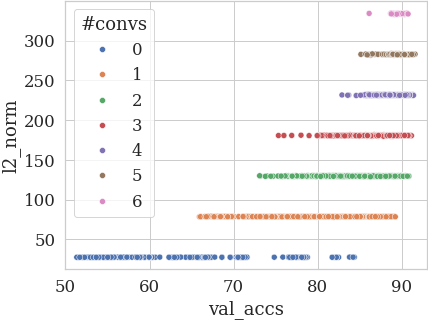

In [101]:
n_palette = len(data['#convs'].unique())

rc = {'text.usetex': False, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015} #'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.titlesize': 8, 'lines.markersize': 25}

sns.set(rc=rc, font_scale=1.5, style='whitegrid')# palette=sns.color_palette()[::-1])
#sns.set_style('whitegrid')

prox = 'nwot'

plt.figure(figsize=(6,4.5))
sns.scatterplot(data=data[data[prox] > 0], y=prox, x=y, hue=data['#convs'], palette=sns.color_palette()[:n_palette])

if bench == 'nb201':
    plt.xlim(50, 93)
    pass
elif bench == 'nb101':
    plt.xlim(63, 96)
elif bench == 'tnb101':
    #plt.xlim(10, 58)
    pass
    

#plt.title(f'All networks in {bench} on {dataset} - {prox} by #convs')
#plt.tight_layout()
plt.savefig(f'figs_update/{bench}_{dataset}_{prox}_nconvs_new.png')
plt.show()

/tmp/ipykernel_10774/63408773.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['#conv3x3'] = data[f'op_count_{id1}']


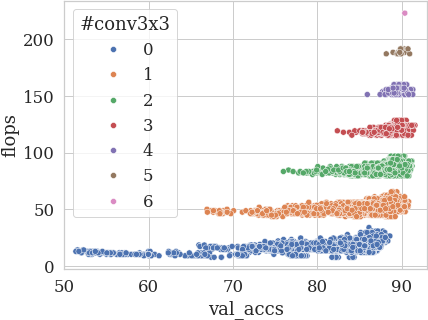

In [102]:

prox = 'flops'

data['#conv3x3'] = data[f'op_count_{id1}']
n_palette = len(data['#conv3x3'].unique())

plt.figure(figsize=(6, 4.5))
sns.scatterplot(data=data[data[prox] > 0], y=prox, x=y, hue=data['#conv3x3'], palette=sns.color_palette()[:n_palette])

if bench == 'nb201':
    plt.xlim(50, 93)
elif bench == 'nb101':
    plt.xlim(63, 96)
elif bench == 'tnb101':
    #plt.xlim(10, 58)
    pass

#plt.title(f'All networks in {bench} on {dataset} - {prox} by #conv3x3')
#plt.tight_layout()
plt.savefig(f'figs_update/{bench}_{prox}_n3x3.png')
plt.show()

In [103]:
proxies = [c for c in data.columns if 'op_' not in c and '(' not in c and c not in ['net', '#convs', '#conv3x3']]
print(proxies)

['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen']


In [104]:
import scipy.stats
import pandas as pd


compute_tau = False
res_corrs = []

data['#conv3x3'] = data[f'op_count_{id1}']

key = '#convs'

def get_corr(d):
    return {k: func(d[k], y[d.index])[0] for k in proxies}


for nc in sorted(data[key].unique()):    
    filtnets = data[data[key] == nc]
    if len(filtnets) < 2:
        continue
    
    func = scipy.stats.kendalltau if compute_tau else scipy.stats.spearmanr
    
    res = get_corr(filtnets)
    res = {key: nc, **res}
    res_corrs.append(res)
    
res_all = get_corr(data)
res_all = {key: 'all data', **res_all}
res_corrs.append(res_all)

df = pd.DataFrame(res_corrs)
df.T 

/home/gabi/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,0,1,2,3,4,5,6,7
#convs,0,1,2,3,4,5,6,all data
epe_nas,0.353338,0.675375,0.742278,0.563117,0.265183,-0.029485,-0.193639,0.787009
fisher,-0.033714,0.35616,0.277897,-0.088109,-0.144294,-0.101163,0.263635,0.501246
flops,-0.619249,-0.118364,0.060551,0.200919,0.306736,0.426278,0.520598,0.714112
grad_norm,0.024039,0.367281,0.300123,-0.074912,-0.132839,-0.05844,0.211682,0.549981
grasp,0.109442,0.35827,0.265862,-0.067694,-0.009929,-0.001401,-0.045267,0.490862
jacov,0.603425,0.75145,0.787218,0.60176,0.318973,-0.010088,-0.342286,0.818347
l2_norm,-0.026181,-0.004785,0.008288,0.009437,0.009853,-0.047698,0.109494,0.719783
nwot,0.339777,0.651922,0.657814,0.401186,0.101791,-0.1479,-0.125612,0.792169
params,NaN,0.200706,0.288111,0.377915,0.418415,0.478862,0.520598,0.747097


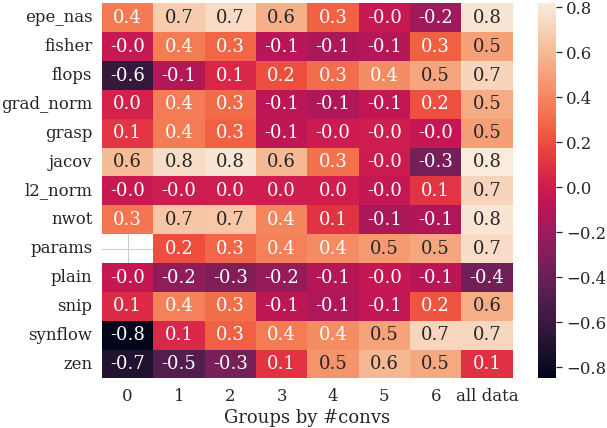

In [105]:
heatdf = df.T
heatdf.rename(columns=heatdf.iloc[0], inplace=True)
heatdf.drop(heatdf.index[0], inplace=True)

#sns.set(font_scale=1.3)

#plt.rcParams.update({'text.usetex': False, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 18, 'axes.labelsize': 20, 'legend.fontsize': 6, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.titlesize': 20})
#sns.set(font_scale=1.5)# palette=sns.color_palette()[::-1])
#sns.set_style('whitegrid')

plt.figure(figsize=(8.5, 6))
sns.heatmap(data=heatdf.astype(float), annot=True, fmt=".1f")
plt.xlabel(f"Groups by {key}")
#plt.title(f'{bench} {dataset} - spearman corr by {key}')
#plt.tight_layout()
plt.savefig(f'figs_update/heat_{bench}_{key[1:]}.pdf')
plt.show()

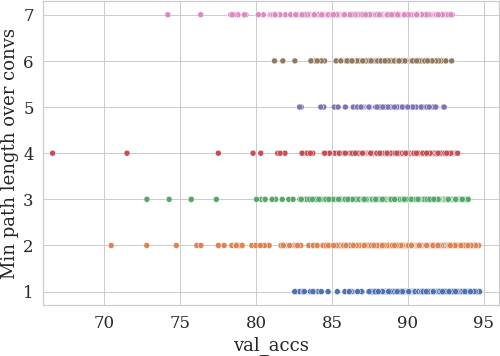

In [80]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=data, y='min_path_len_banned_(2)', x=y, hue='min_path_len_banned_(2)', legend=False, palette=sns.color_palette()[:7])
plt.xlim(66, 96)
#plt.title(f'All networks in {bench} - min path length over convs')
plt.ylabel('Min path length over convs')
plt.savefig(f'figs_update/min_path_{bench}.png')
plt.show()

In [33]:
data.columns

Index(['op_count_0', 'op_count_1', 'op_count_2', 'op_count_3', 'op_count_4',
       'min_path_len_banned_()', 'min_path_len_banned_(2)',
       'min_path_len_banned_(3)', 'min_path_len_banned_(4)',
       'min_path_len_banned_(2, 3)', 'min_path_len_banned_(2, 4)',
       'min_path_len_banned_(3, 4)', 'max_op_on_path_allowed_(2)',
       'max_op_on_path_allowed_(3)', 'max_op_on_path_allowed_(4)',
       'max_op_on_path_allowed_(2, 3)', 'max_op_on_path_allowed_(2, 4)',
       'max_op_on_path_allowed_(3, 4)', 'max_op_on_path_allowed_(2, 3, 4)',
       'node_degree_allowed_(2)_in_degree',
       'node_degree_allowed_(2)_out_degree', 'node_degree_allowed_(2)_avg_in',
       'node_degree_allowed_(2)_avg_out', 'node_degree_allowed_(2)_max_out',
       'node_degree_allowed_(2)_max_in', 'node_degree_allowed_(3)_in_degree',
       'node_degree_allowed_(3)_out_degree', 'node_degree_allowed_(3)_avg_in',
       'node_degree_allowed_(3)_avg_out', 'node_degree_allowed_(3)_max_out',
       'node_degre